In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
database_path = "../Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [5]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [9]:
from sqlalchemy import inspect

inspector = inspect(engine)
inspector.get_table_names()
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Find the most recent date in the data set.
engine.execute('select max(date) from measurement'). fetchall()[0][0]

'2017-08-23'

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent_date

'2017-08-23'

## Design a query to retrieve the last 12 months of precipitation data and plot the results. 

In [14]:
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

from dateutil.relativedelta import relativedelta
previous_year_date = dt.strptime(recent_date, "%Y-%m-%d") + relativedelta(years=-1)
print(previous_year_date)

2016-08-23 00:00:00


In [17]:
# Perform a query to retrieve the data and precipitation scores
resultSet = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= previous_year_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitationDF = pd.DataFrame(data = resultSet, columns = ['date', 'precipitation'])

# Sort the dataframe by date
precipitationDF.sort_values(by=['date'], inplace=True)

precipitationDF['precipitation'].value_counts(dropna=False).sort_values()

# Since the dataframe has missing na values, clearing the dataframe before plotting the data
precipitationDF.dropna(axis=0, how='any', inplace=True)
precipitationDF['precipitation'].value_counts(dropna=False).sort_values()
precipitationDF

,date,precipitation
0,2016-08-24,0.08
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
1875,2016-08-24,1.45
...,...,...
1522,2017-08-22,0.00
1523,2017-08-23,0.08
359,2017-08-23,0.00
1005,2017-08-23,0.00


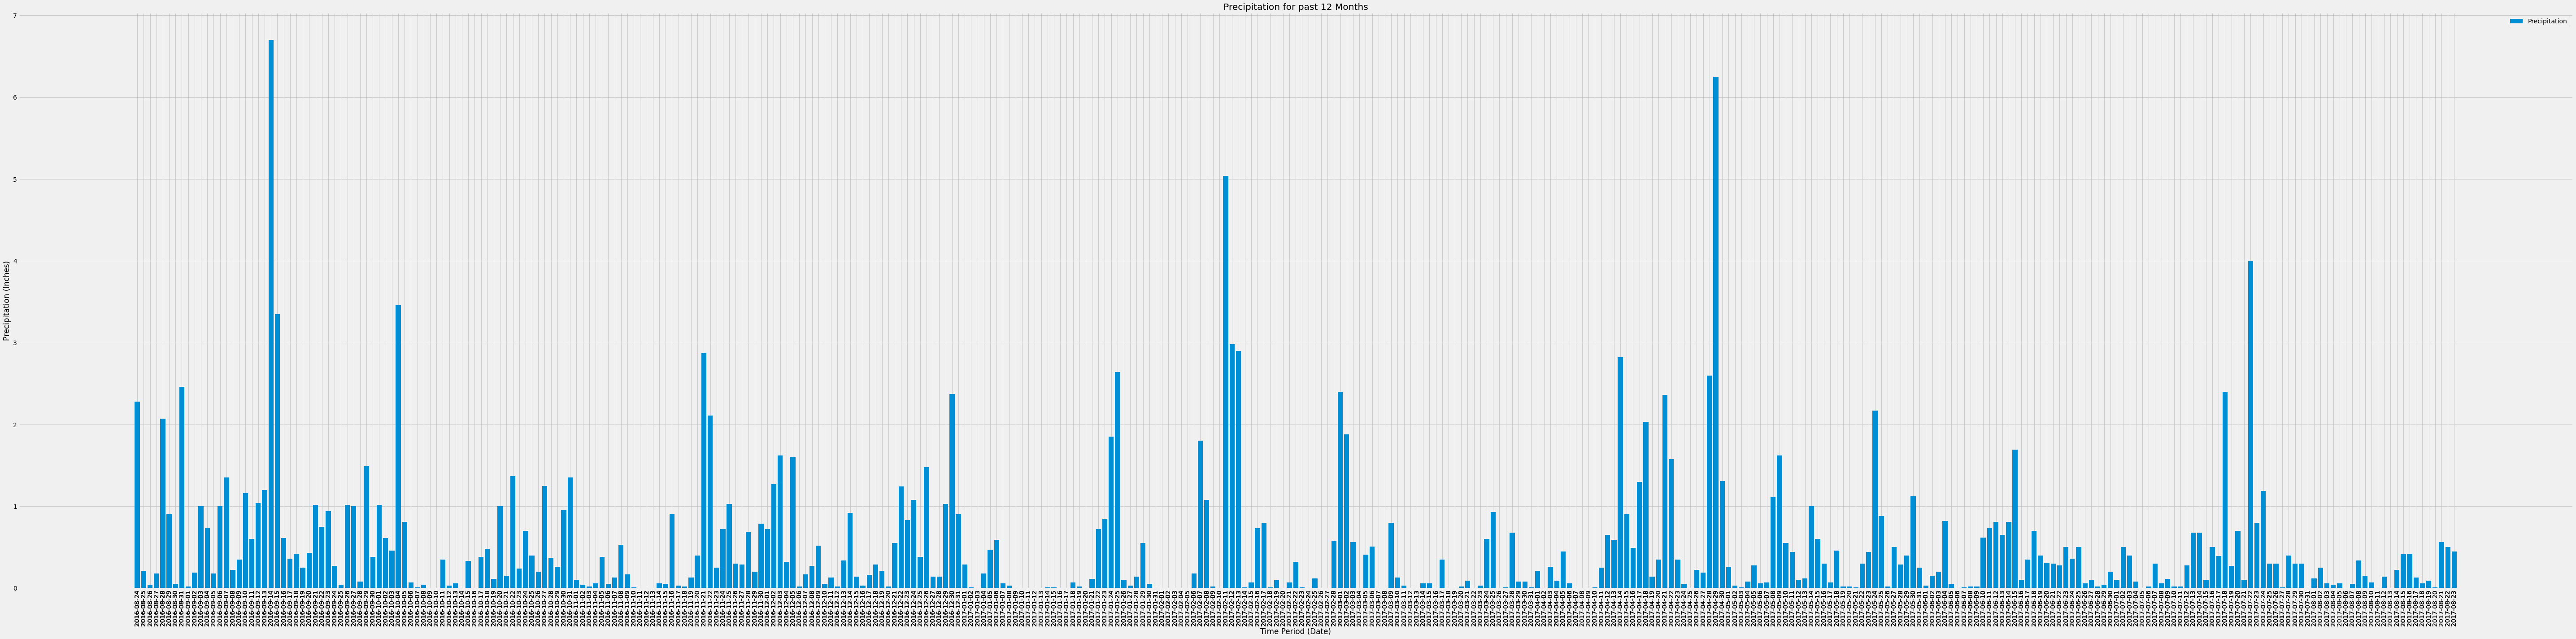

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(80,20))
plt.title('Precipitation for past 12 Months')
plt.bar(x=precipitationDF['date'], height=precipitationDF['precipitation'], label='Precipitation', align="center")
plt.xticks(ticks=precipitationDF['date'], rotation=90)
plt.xlabel('Time Period (Date)')
plt.ylabel('Precipitation (Inches)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../Images/PrecipitationForYear.png')
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitationDF.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number stations in the dataset
stationCount = session.query(Station).count()
print(f"Total number of stations: {stationCount}")

Total number of stations: 9


In [22]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

from sqlalchemy import func, desc
resultSet = session.query(
                        Measurement.station,
                        Station.name,
                        func.count(Measurement.id).label('count')
                        ).\
                        join(Station, Measurement.station == Station.station).\
                        group_by(Measurement.station).\
                        order_by(desc('count')).\
                        all()

# List the stations and the counts in descending order.
for row in resultSet:
    print(row)

('USC00519281', 'WAIHEE 837.5, HI US', 2772)
('USC00519397', 'WAIKIKI 717.2, HI US', 2724)
('USC00513117', 'KANEOHE 838.1, HI US', 2709)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979)
('USC00517948', 'PEARL CITY, HI US', 1372)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# As the resultset is sorted in descending order, the first row in the list is considered the most active station. 
mostActiveStation = resultSet[0]
activeStationID = mostActiveStation.station
activeStationName = mostActiveStation.name
print('------------------------------------------------------------------------')
print(f"Most Active Station is *{activeStationName}* with Station ID *{mostActiveStation.station}*")
print('------------------------------------------------------------------------')

minimumTemperature = session.query(func.min(Measurement.tobs)).filter(Measurement.station == activeStationID).first()[0]
maximumTemperature = session.query(func.max(Measurement.tobs)).filter(Measurement.station == activeStationID).first()[0]
averageTemperature = round(session.query(func.avg(Measurement.tobs)).filter(Measurement.station == activeStationID).first()[0],2)

print(f"Lowest Temperature recorded at the station *{activeStationName}* is {minimumTemperature}")
print(f"Highest Temperature recorded at the station *{activeStationName}* is {maximumTemperature}")
print(f"Average Temperature at the station *{activeStationName}* is calculated to be {averageTemperature}")
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Most Active Station is *WAIHEE 837.5, HI US* with Station ID *USC00519281*
------------------------------------------------------------------------
Lowest Temperature recorded at the station *WAIHEE 837.5, HI US* is 54.0
Highest Temperature recorded at the station *WAIHEE 837.5, HI US* is 85.0
Average Temperature at the station *WAIHEE 837.5, HI US* is calculated to be 71.66
------------------------------------------------------------------------


In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

resultSet = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == activeStationID).filter(Measurement.date >= previous_year_date).all()

temperatureDF = pd.DataFrame(data = resultSet, columns=['date', 'temperature'])

# Drop any missing/na values before plotting the graph

temperatureDF.dropna(inplace=True)
temperatureDF

,date,temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


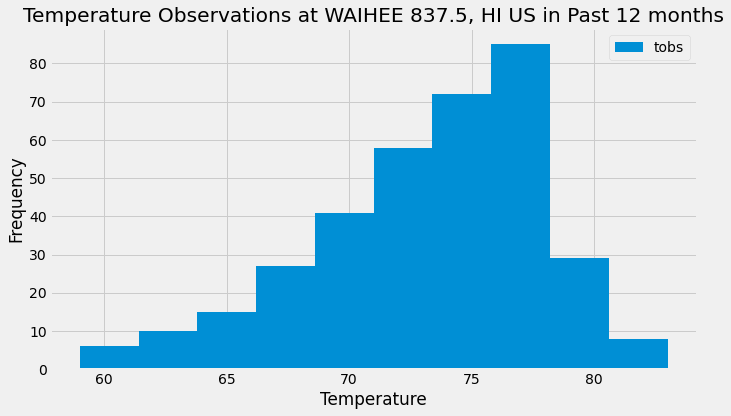

In [25]:
# Plot Temperature observations data as a histogram

plt.figure(figsize = (10,6))
plt.hist(temperatureDF['temperature'], label = 'tobs')
plt.title(f'Temperature Observations at {activeStationName} in Past 12 months')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../Images/TemperatureObservationsForYear.png')
plt.show()

# Close session

In [26]:
# Close Session
session.close()